# YouTube Watch History Data Analysis

YouTube has become an essential part of many people's daily lives. It serves as a platform for entertainment, learning, and relaxation. This analysis aims to achieve general descriptive approaches to provide a comprehensive understanding of YouTube data insights and usage habits.

The YouTube data is from my acquaintance, credits to her (Mary Horca)

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
from wordcloud import WordCloud
from datetime import datetime, timedelta
%matplotlib inline

## Read the dataset on a dataframe

In [2]:
file = 'youtube_data.csv'
df = pd.read_csv(file)

In [3]:
# Let's take a peak at the dataset
df.head(3)

,title,url,video_duration,channel_name,channel_url,date_time,video_date_upload,video_category,video_views,video_likes,video_comment_count,video_description,video_tags
0,Can I Call You Tonight?,https://www.youtube.com/watch?v=n-IwmbARwBo,00:04:39,Dayglow - Topic,https://www.youtube.com/channel/UCyMwUmEqTBsHj...,"Jun 23, 2024, 08:16:46 PM",2019-08-15 20:42:13,Music,66955059.0,680946.0,2178.0,Provided to YouTube by Repost Network\n\nCan I...,"Dayglow,Can I Call You Tonight?"
1,The Moment,https://www.youtube.com/watch?v=Mv0oYS-qMcQ,00:04:16,Tame Impala - Topic,https://www.youtube.com/channel/UCGz-eguN8tcic...,"Jun 23, 2024, 08:15:26 PM",2018-07-24 16:33:01,Music,15468207.0,118340.0,693.0,Provided to YouTube by Universal Music Group\n...,"Tame Impala,テームインパラ,テーム・インパラ,Currents,The Moment"
2,Eventually,https://www.youtube.com/watch?v=YifOMt9dlGk,00:05:19,Tame Impala - Topic,https://www.youtube.com/channel/UCGz-eguN8tcic...,"Jun 23, 2024, 08:09:59 PM",2018-07-24 16:35:44,Music,25523570.0,264766.0,849.0,Provided to YouTube by Universal Music Group\n...,"Tame Impala,テームインパラ,テーム・インパラ,Currents,Eventually"


In [4]:
df.shape

(4652, 13)

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1844 non-null   object
 1   url                  1844 non-null   object
 2   video_duration       1844 non-null   object
 3   channel_name         1844 non-null   object
 4   channel_url          1844 non-null   object
 5   date_time            1844 non-null   object
 6   video_date_upload    1844 non-null   object
 7   video_category       1844 non-null   object
 8   video_views          1844 non-null   int64 
 9   video_likes          1844 non-null   int64 
 10  video_comment_count  1844 non-null   int64 
 11  video_description    1510 non-null   object
 12  video_tags           1308 non-null   object
dtypes: int64(3), object(10)
memory usage: 187.4+ KB


Only columns for video description and tags are optionally allowed to be empty, as some videos don't have any of them. It seems there are missing values in some rows because there is an inconsistency in the non-null count in the table above. This means our API script has failed to return further information on these specific videos. From my investigation, these videos have been removed or deleted on YouTube, which is why the YouTube API can't retrieve information such as like counts. Unfortunately, this means that we won't be able to include these videos in our analysis

In [5]:
# check for total missing values for each column in dataframe
df.isna().sum()

title                     0
url                       0
video_duration            4
channel_name              0
channel_url               0
date_time                 0
video_date_upload         4
video_category            4
video_views               4
video_likes               4
video_comment_count       4
video_description       377
video_tags             1352
dtype: int64

In [6]:
# Drop rows with more than two null values.
df.dropna(axis=0, thresh=len(df.columns) - 2, inplace=True)

df.to_csv('youtube_data.csv', index=False)

## Check for duplicate rows

In [7]:
duplicated = df[df.duplicated(keep=False)]
print("There are {} duplicated rows.".format(len(duplicated)))

There are 0 duplicated rows.


In [8]:
pd.set_option('display.float_format', '{:.2f}'.format)

df.describe()

,video_views,video_likes,video_comment_count
count,4648.00,4648.00,4648.00
mean,116759478.64,749057.89,22486.07
std,396676812.34,2222509.82,96774.85
min,30.00,0.00,0.00
25%,1794770.25,14407.00,160.00
50%,7883186.00,68767.00,698.50
75%,38174803.00,337076.50,4906.50
max,8471685226.00,53404493.00,4259490.00


## YouTube Watch History Analysis

In this section, various aspects of the data will be explored to gain a better understanding. Specifically, the analysis will cover:

1. **Determine the start date and end date**
2. **Determine the number of videos watched each week given the timeframe**
3. **Determine the specific days when the most videos were watched**
4. **Calculate the average number of videos watched per day**
5. **Identify the top 10 most viewed videos on YouTube in the past three months**
6. **Plot the ratio between regular YouTube videos and YouTube Shorts**
7. **Determine the average watch time of regular YouTube videos and YouTube Shorts per day**
8. **Determine the most favorite YouTube videos by the number of times they were watched each month**
9. **Identify the most common keywords or substrings in all video titles, tags, and descriptions**
10. **Identify the most favorite channels**
11. **Determine the longest timeframe without watching YouTube**
12. **Identify the oldest video uploaded on YouTube in the watch history**
13. **Discover the most liked and most commented videos on YouTube in the watch history**
14. **Find out YouTube videos that were posted on the same day as a specific birthday**
15. **Determine the videos with the longest duration**
16. **Identify the frequency of videos watched based on their duration (minutes)**
17. **Identify the frequency of YouTube videos watched based on the year they were uploaded**
18. **Determine the frequency of videos watched based on video categories**
19. **Determine the total watch time by each category**
20. **Discover what time and day of the week YouTube is often watched**

## Determine the start date and end date

In [9]:
# The YouTube data is sorted in date from newest to oldest
start_date = df.iloc[-1]['date_time']
end_date = df.iloc[0]['date_time']

print("Start date: ", start_date)
print("End date: ", end_date)

Start date:  Nov 08, 2023, 01:54:54 PM
End date:  Jun 23, 2024, 08:16:46 PM


## Determine the total watch time on YouTube

In [12]:
total_time = df.copy()

def time_convert(x):
    h,m,s = map(int,x.split(':'))
    return (h*60+m)*60+s

total_time['video_duration'] = total_time['video_duration'].astype('str').apply(time_convert)
watch_time = total_time['video_duration'].sum() / 3600
print(f"Total Watch Time on YouTube (November 8, 2023 - June 23, 2024): {round(watch_time)} hours")

Total Watch Time on YouTube (November 8, 2023 - June 23, 2024): 739 hours


## Determine the average time spent on watching videos on YouTube per day

In [13]:
avg_watch_time = total_time['video_duration'].mean()
print(f"The average time spent watching videos on YouTube is {round(avg_watch_time / 60)} minutes.")

The average time spent watching videos on YouTube is 10 minutes.


## Determine the total number of videos watched for each week

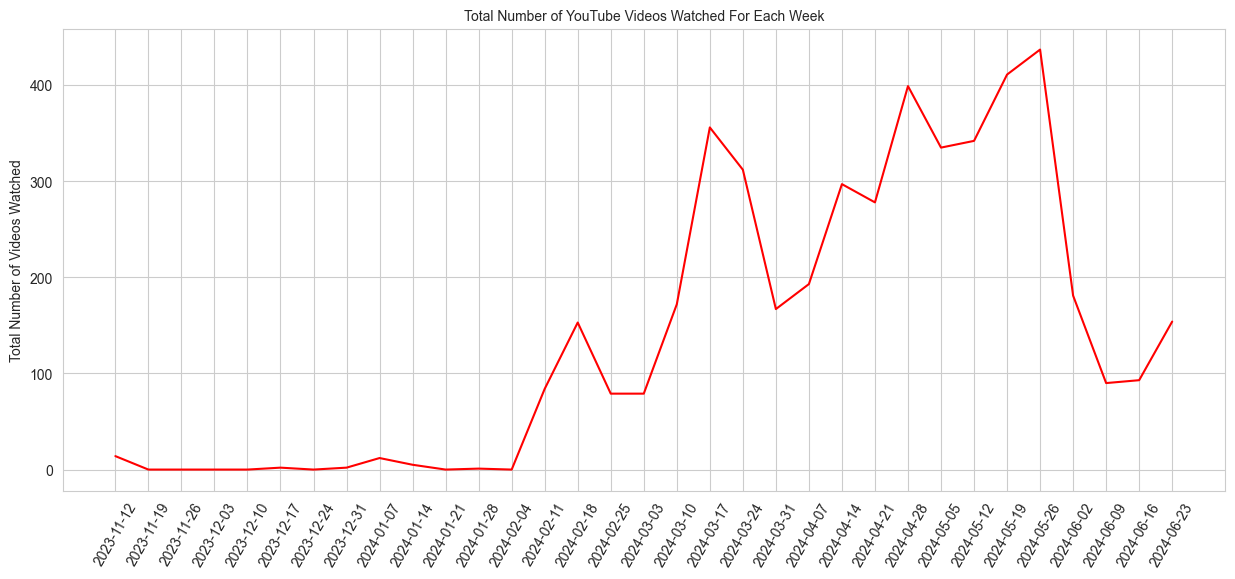

In [18]:
# Sort from oldest to newest
df_sorted = df.copy()
df_sorted = df_sorted.sort_values(by='date_time')

df_sorted['date_time'] = pd.to_datetime(df_sorted['date_time'], format='%b %d, %Y, %I:%M:%S %p')

# Set the 'date_time' column as the index
df_sorted.set_index('date_time', inplace=True)

# Uncomment to not include re-watched videos
# df_sorted = df_sorted.drop_duplicates(subset='title', keep='first')

# Resample the data by week and count the occurrences
weekly_counts = df_sorted.resample('W').size()

# Reset the index to make the 'date_time' column again
weekly_counts = weekly_counts.reset_index(name='frequency')

# Display the result
dates = weekly_counts['date_time'].astype('str')
videos = weekly_counts['frequency']

# Customize the graph to show
plt.figure(figsize=(15, 6), facecolor='white')
plt.title('Total Number of YouTube Videos Watched For Each Week', size=10)
plt.ylabel('Total Number of Videos Watched')
plt.xticks(rotation=60)
plt.plot(dates, videos, color='red')
plt.show()

## Determine the specific days when the most videos were watched

In [61]:
# Resample the data by day and count the occurrences
daily_counts = df_sorted.resample('D').size()
# Reset the index to make the 'date_time' column again
daily_counts = daily_counts.reset_index(name='frequency')
daily_counts.sort_values('frequency', ascending=False)[:10].reset_index(drop=True)

,date_time,frequency
0,2024-05-18,155
1,2024-05-22,136
2,2024-05-20,130
3,2024-04-26,121
4,2024-05-10,116
5,2024-03-20,110
6,2024-03-17,107
7,2024-05-26,106
8,2024-05-03,94
9,2024-04-27,94


## Calculate the average watch per day

In [20]:
print(f"The average number of videos watched per day from February 20 to June 02, 2024, is {round(daily_counts['frequency'].mean())} videos.")

The average number of videos watched per day from February 20 to June 02, 2024, is 20 videos.


## Identify the top 10 most viewed video watched on YouTube history

Excluding YouTube Shorts or technically short videos

In [21]:
# Apply condition to filter the rows
condition = ((df_sorted['title'].str.contains('#shorts', case=False)) |
             (pd.to_timedelta(df_sorted['video_duration']).dt.total_seconds() <= 61))

# Only include the YouTube Regular Videos, negate the condition
filtered_df = df_sorted[~condition].reset_index(drop=True)
# Only include distinct videos
filtered_df = filtered_df.drop_duplicates(subset='title', keep='first')
# Sort by 'video_views' in descending order and get the top 10 videos
filtered_df = filtered_df.sort_values('video_views', ascending=False)[['title', 'video_views']][:10].reset_index(drop=True)
# Put commas for better readability
filtered_df['video_views'] = filtered_df['video_views'].apply(lambda x: "{:,}".format(x))
filtered_df


,title,video_views
0,Luis Fonsi - Despacito ft. Daddy Yankee,"8,471,685,226.0"
1,Mark Ronson - Uptown Funk (Official Video) ft....,"5,260,333,046.0"
2,Ed Sheeran - Perfect (Official Music Video),"3,757,656,628.0"
3,Passenger | Let Her Go (Official Video),"3,678,711,999.0"
4,Charlie Puth - We Don't Talk Anymore (feat. Se...,"3,183,042,590.0"
5,The Chainsmokers - Closer (Lyric) ft. Halsey,"3,072,438,578.0"
6,Eminem - Love The Way You Lie ft. Rihanna,"2,820,102,016.0"
7,Bruno Mars - The Lazy Song (Official Music Video),"2,775,191,786.0"
8,Adele - Rolling in the Deep (Official Music Vi...,"2,528,402,834.0"
9,MAGIC! - Rude (Official Video),"2,496,742,740.0"


## Plot the ratio between regular YouTube videos and YouTube shorts

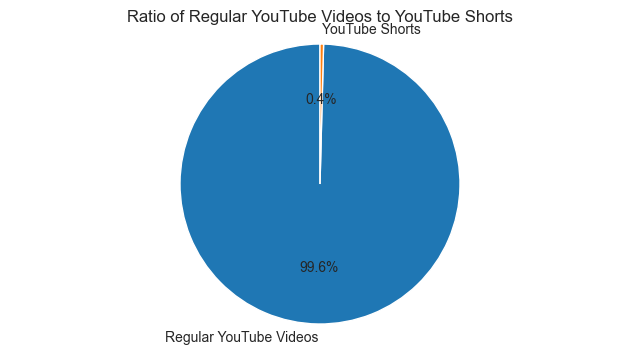

In [22]:
# Count the total number of YouTube Shorts viewed/watched
video_shorts_count = ((df['title'].str.contains('#shorts', case=False)) |
         (pd.to_timedelta(df['video_duration']).dt.total_seconds() <= 61)).sum()
# Subtract the number of shorts to the total number of videos to get the normal video total count
video_normal_count = df.shape[0] - video_shorts_count

counts = [video_normal_count, video_shorts_count]

# Create a pie chart
plt.figure(figsize=(8, 4))
plt.pie(counts, labels=['Regular YouTube Videos', 'YouTube Shorts'], autopct='%1.1f%%', startangle=90)
plt.title('Ratio of Regular YouTube Videos to YouTube Shorts')
plt.axis('equal')
plt.show()

## Determine the average watch times of regular YouTube videos and YouTube Shorts per day

In [23]:
# Generate condition to filter YouTube Shorts in the dataset
condition =  ((df['title'].str.contains('#shorts', case=False)) |
         (pd.to_timedelta(df['video_duration']).dt.total_seconds() <= 61))
# Get the total number of YouTube Shorts
video_shorts_count = len(df[condition])
# Get the total number of Regular YouTube videos
regular_videos_count = len(df[~condition])
# Get the total number of days given the timeframe
total_number_of_days = daily_counts.shape[0]

# Calculate the average watch per day
video_shorts_avg = video_shorts_count / total_number_of_days
regular_videos_avg = regular_videos_count / total_number_of_days

print(f"The average number of YouTube Shorts watched per day from February 20 to June 02, 2024, is {round(video_shorts_avg)}.\n")
print(f"The average number of Regular YouTube videos watched per day from February 20 to June 02, 2024, is {round(regular_videos_avg)}.")

The average number of YouTube Shorts watched per day from February 20 to June 02, 2024, is 0.

The average number of Regular YouTube videos watched per day from February 20 to June 02, 2024, is 20.


## Determine the most favorite YouTube Videos by the number of times they were watched, and by each month.

In [24]:
# Count the number of occurrence of each video
most_favorite_videos = df.groupby('title').size().reset_index(name='frequency')

# Sort by the 'count' column in descending order
sorted_counts = most_favorite_videos.sort_values('frequency', ascending=False)

# Determine the threshold count value for the top 10 counts
threshold_count = sorted_counts['frequency'].nlargest(10).min()

# Filter the rows to include all those with count values equal to or above the threshold
top_counts = sorted_counts[sorted_counts['frequency'] >= threshold_count]
top_counts.reset_index(drop=True)

,title,frequency
0,Ariana Grande - we can't be friends (wait for ...,46
1,Ariana Grande - eternal sunshine (lyric visual...,29
2,Ribs,25
3,"CHROMATICS ""GIRLS JUST WANNA HAVE SOME"" (Offic...",24
4,Never Be Like You (speed up) ★,24
5,Supercut,22
6,G-Eazy & Halsey - Him & I (Lyrics),20
7,is there someone else? - the weeknd (sped up),20
8,the weeknd - save your tears (sped up),20
9,taylor swift - style (sped up),19


## Determine the most favorite videos for each month

We define the 'favorite video' as having watch the video 8 or more times.

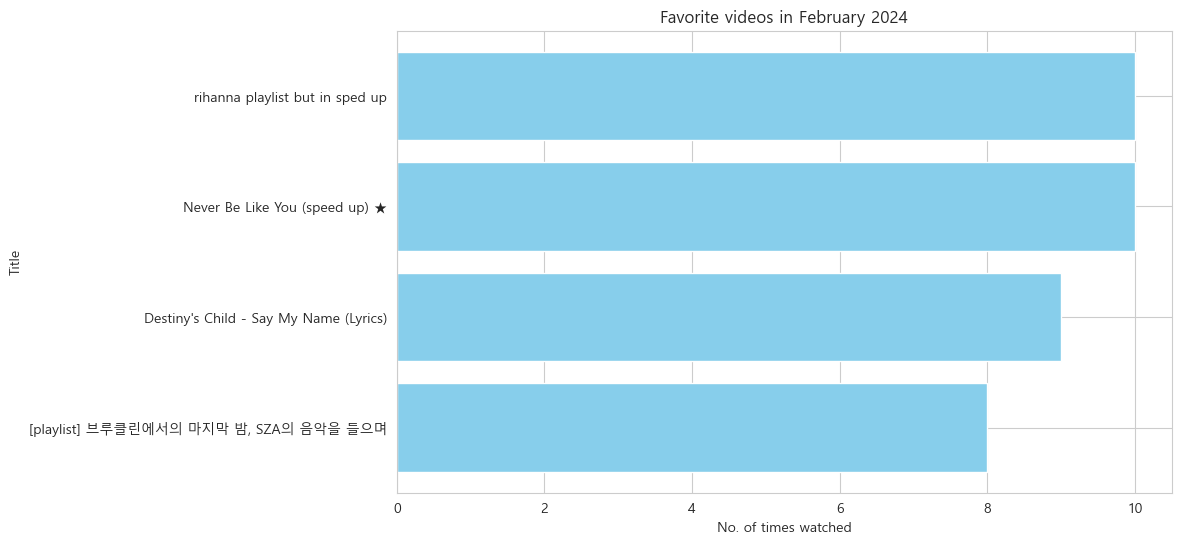

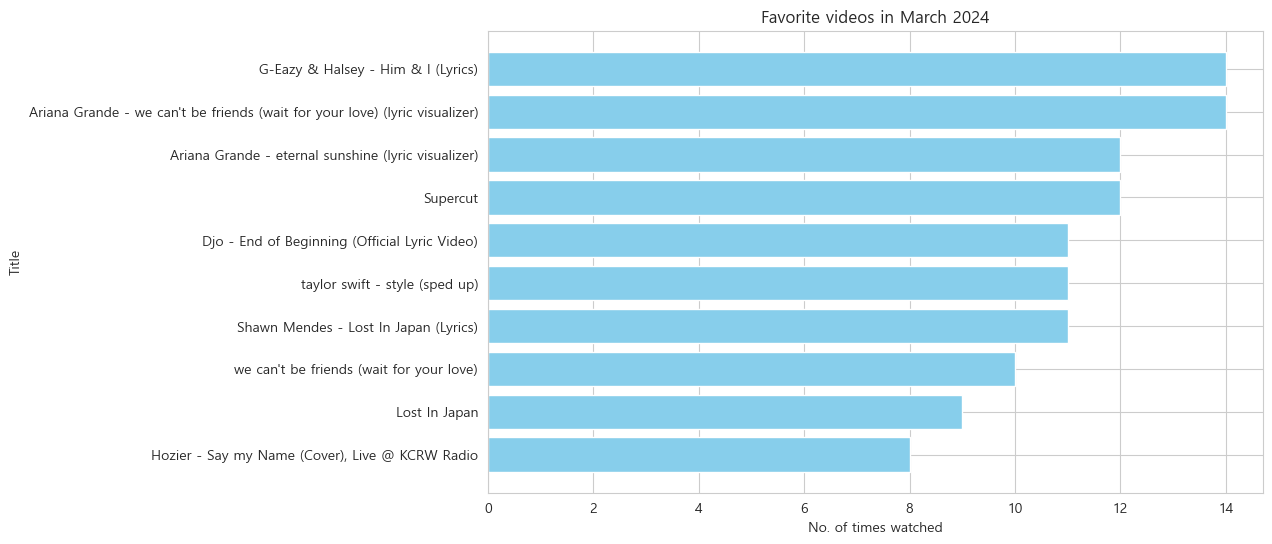

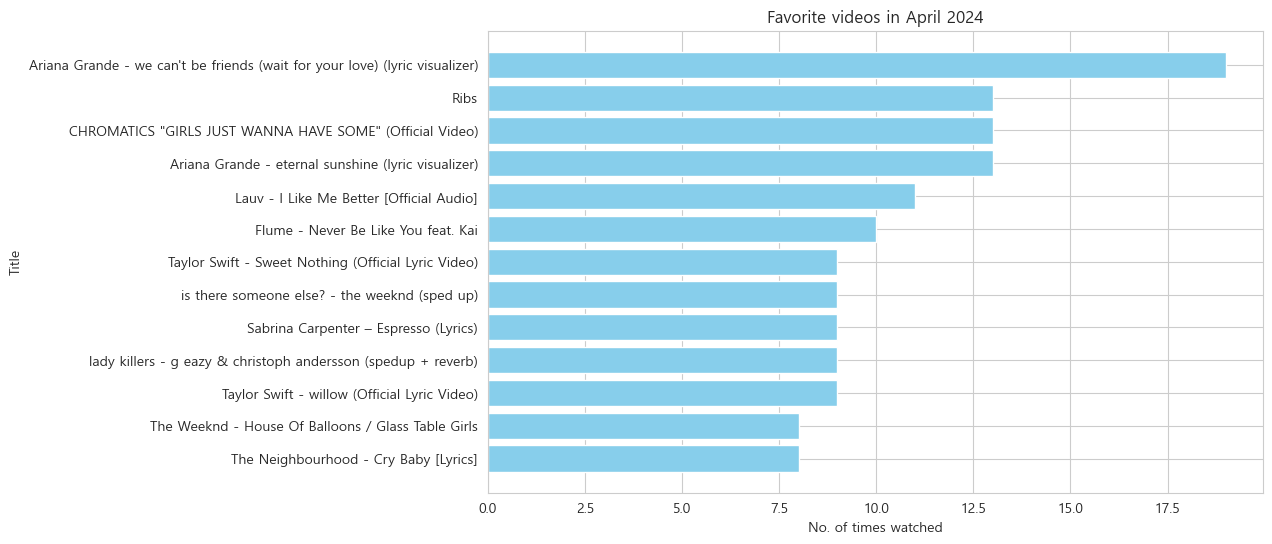

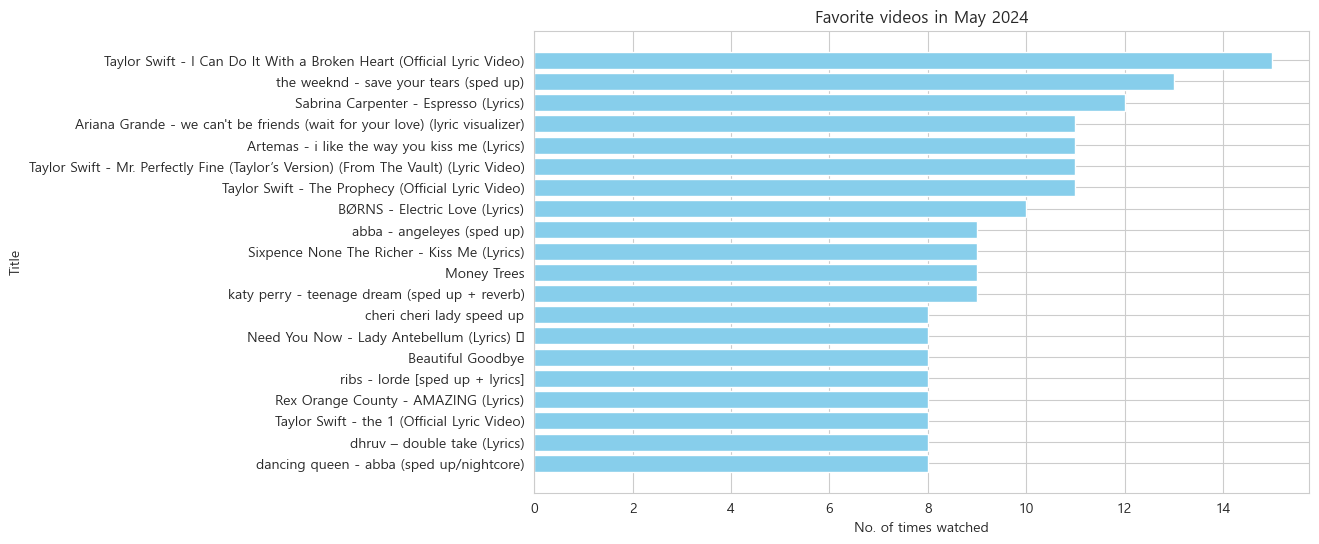

In [33]:
import warnings

# Filter specific warnings
warnings.filterwarnings('ignore', category=UserWarning, message="Glyph .* missing from font.*")


fav = df.copy()
# Convert the 'date_time' column into a datetime object
fav['date_time'] = pd.to_datetime(fav['date_time'], format='%b %d, %Y, %I:%M:%S %p')
# Create new column that specifies what month a video was viewed
fav['month'] = fav['date_time'].dt.month
# Sort the data by month, so we can start in ascending order
fav = fav.sort_values('month', ascending=True)
# Store the months covered into a list
Months = list(fav['month'].unique())

# Store each data grouped by month into dict
dfs = {}

month_name = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    11: 'November',
    12: 'December'
}


# Set the global font properties to a font that supports Hangul
plt.rcParams['font.family'] = 'Malgun Gothic'  # or 'Malgun Gothic' or 'Noto Sans CJK'

# Fill in the dfs dictionary with dataframes for each month (key = month number, value = dataframe)
for month in Months:
    dfs[month] = fav[fav['month'] == month]

# Plot each month data
for month, monthly_df in dfs.items():
    most_favorite_video = monthly_df.groupby('title').size().reset_index(name='frequency')

    sorted_counts = most_favorite_video.sort_values('frequency', ascending=False)
    
    # Filter the rows to include all those with count values equal to or above the threshold
    top_counts = sorted_counts[sorted_counts['frequency'] >= 8]
    
    # Plot only if there are favorites in the month
    if not top_counts.empty:
        titles = top_counts['title']
        watched = top_counts['frequency']
        plt.figure(figsize=(10, 6))
        plt.barh(titles, watched, color='skyblue')
        plt.xlabel('No. of times watched')
        plt.ylabel('Title')
        plt.title(f'Favorite videos in {month_name[month]} 2024')
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
        plt.show()
        

## Identify the most common keyword in YouTube Titles, Tags, and Descriptions

In [34]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Asus
[nltk_data]     Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
def create_wordcloud(data):
    # Generate a word cloud image
    word_cloud = WordCloud().generate_from_frequencies(data)
    # Display the generated image
    plt.figure(figsize=(10, 5))  # Adjust the size of the plot
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

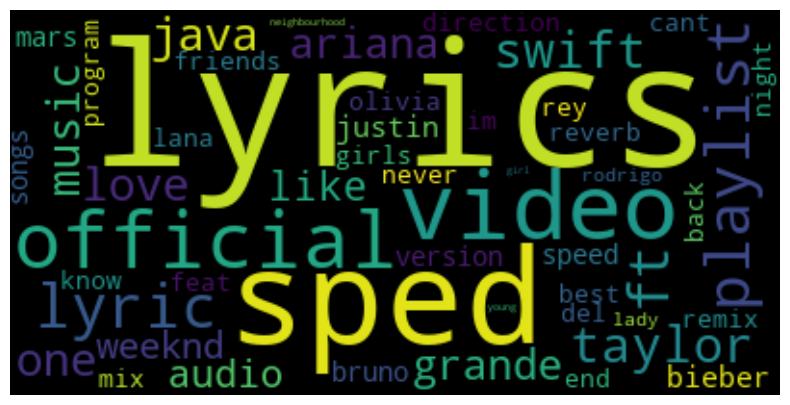

In [64]:
def count_words(data_title, filter_words):
    words = defaultdict(int)
        
    for keywords in data_title['title']:
        for key in keywords.split():
            # Use regex to filter out non-alphabetic characters
            key = re.sub(r'[^a-zA-Z0-9]', '', key)
            if key and key.lower() not in filter_words and len(key) > 1:
                words[key.lower()] += 1
        
    # Convert dictionary to DataFrame
    return pd.DataFrame(list(words.items()), columns=['Word', 'Count'])

all_words = df.copy()
all_words = count_words(all_words.drop_duplicates(subset='title', keep='first'), stop_words)
all_words = all_words.sort_values(by='Count', ascending=False).head(50)

# Convert DataFrame to dictionary
word_freq_dict = dict(zip(all_words['Word'], all_words['Count']))

create_wordcloud(word_freq_dict)

## Determine the most common words in video tags

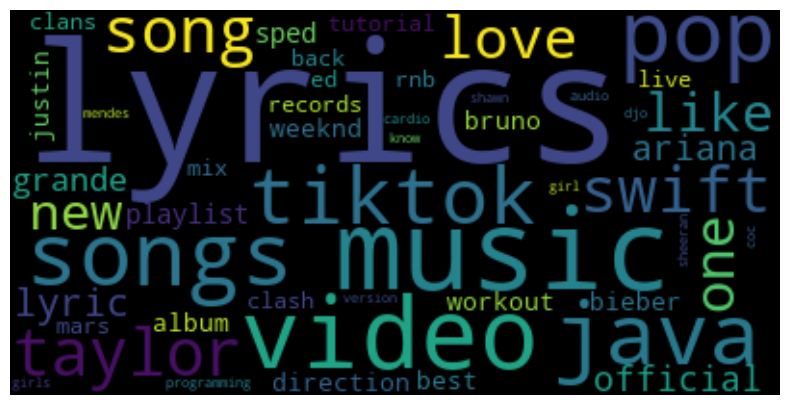

In [65]:
def count_tags(data_tags, filter_words):
    words = defaultdict(int)
        
    for tags in data_tags['video_tags']:
        if isinstance(tags, str):
            for tag in tags.split(','):
                for sub_tag in tag.split():
                    if sub_tag.lower() not in filter_words and sub_tag.lower().isalpha() and len(sub_tag.lower()) > 1: 
                        words[sub_tag.lower().strip()] += 1      
        
    # Convert dictionary to DataFrame
    return pd.DataFrame(list(words.items()), columns=['Word', 'Count'])

all_tags = df.copy()
all_tags = all_tags.drop_duplicates(subset='title', keep='first')
all_tags = count_tags(all_tags, stop_words)
all_tags = all_tags.sort_values(by='Count', ascending=False).head(50)

# Convert DataFrame to dictionary
word_freq_dict = dict(zip(all_tags['Word'], all_tags['Count']))

create_wordcloud(word_freq_dict)

## Determine the most common words in video descriptions

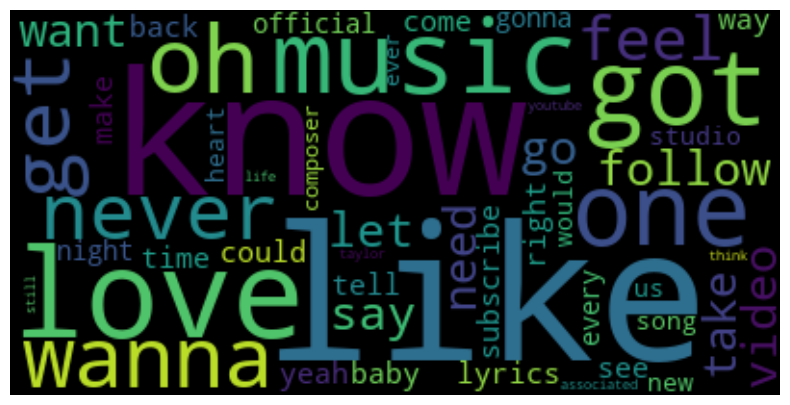

In [66]:
def count_tags(data_tags, filter_words):
    words = defaultdict(int)
                          
    for description in data_tags['video_description']:
        if isinstance(description, str):
            for word in description.split():
                if word.lower() not in filter_words and word.lower().isalpha() and len(word) > 1:
                    words[word.lower().strip()] += 1
        
    # Convert dictionary to DataFrame
    return pd.DataFrame(list(words.items()), columns=['Word', 'Count'])

all_description = df.copy()
all_description = all_description.drop_duplicates(subset='video_description', keep='first')
all_description = count_tags(all_description, stop_words)
all_description = all_description.sort_values(by='Count', ascending=False).head(50)

# Convert DataFrame to dictionary
word_freq_dict = dict(zip(all_description['Word'], all_description['Count']))

create_wordcloud(word_freq_dict)

## Determine the Favorite YouTube Channels

A 'favorite YouTube channel' is defined as one where more than 30 videos have been watched, including re-watched content.

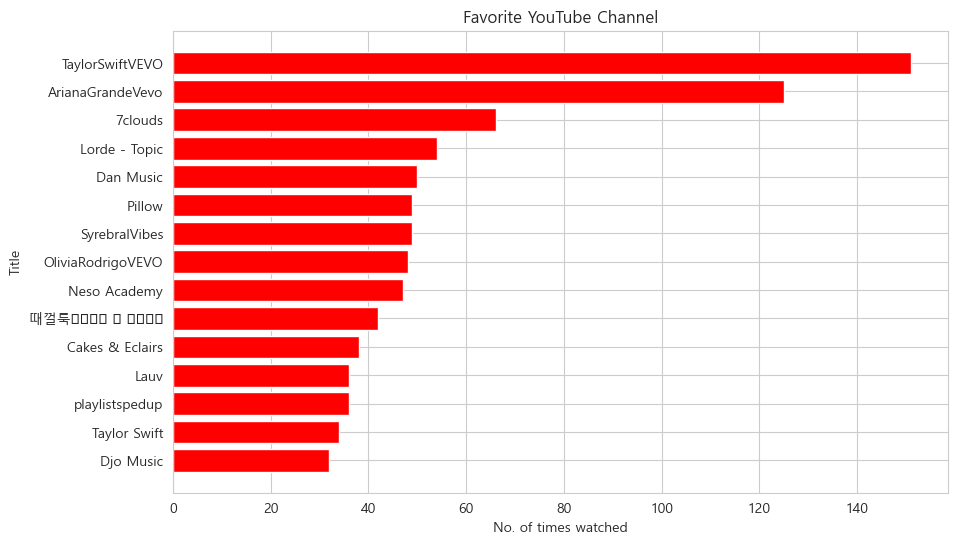

In [45]:
## create a function to count the occurrence of channel names
def count_channel(data, threshold=30):
    channel_df = data.groupby('channel_name').size().reset_index(name='frequency')
    channel_df = channel_df.sort_values(by='frequency', ascending=False)
    channel_df = channel_df[channel_df['frequency'] > threshold]
    return channel_df

channel_data = df.copy()

# Uncomment only if you want to keep distinct videos(re-watched videos aren't considered)
# channel_data = channel_data.drop_duplicates(subset='title', keep='first')

# remove [:1] to show all favorite channels
channel_data = count_channel(channel_data).reset_index(drop=True)

name = channel_data['channel_name']
freq = channel_data['frequency']
plt.figure(figsize=(10, 6))
plt.barh(name, freq, color='red')
plt.xlabel('No. of times watched')
plt.ylabel('Title')
plt.title(f'Favorite YouTube Channel')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.show()

## Determine the longest timeframe without watching on YouTube

In [46]:
start = end = date = frequency = None
max_count = ctr = 0
sequences = []

for date, row in daily_counts.iterrows():
    frequency = row['frequency']
    if frequency == 0:
        ctr += 1
        if start is None:
            start = date
    else:
        if ctr > max_count:
            max_count = ctr
            end = date
            sequences.append((start, end))
        elif ctr == max_count and ctr != 0:
            end = date
            sequences.append((start, end))
        ctr = 0
        start = None

if ctr > max_count:
    if frequency == 0:
        date = date + 1
    max_count = ctr
    end = date
    sequences.append((start, end))
elif ctr == max_count:
    end = date
    sequences.append((start, end))

dates = list(reversed(sequences))
x = dates[0][0]
y = dates[0][1]

for i, pair in enumerate(dates[1:], start=1):
    if pair[1] - pair[0] != y - x:
        del dates[i:]
        break
sequences = dates

for start, end in sequences:
    start_date = str(daily_counts.iloc[start]['date_time'].date())
    end_date = str(daily_counts.iloc[end]['date_time'].date() - timedelta(days=1))
    print(f"You had not watched on YouTube from {start_date} until {end_date}\n")
days = end - start
print(f"That makes it {days} days!")
    

You had not watched on YouTube from 2023-11-09 until 2023-12-13

That makes it 35 days!


## Identify the Oldest Video uploaded on YouTube in your watch History

In [49]:
oldest = df.sort_values(by='video_date_upload', ascending=True)
oldest = oldest.drop_duplicates(subset='title', keep='first')
# modify [:1] base on the number of videos desired to output
oldest[['title', 'video_date_upload', 'url']].reset_index(drop=True)[:10]

,title,video_date_upload,url
0,Mark Morrison - Return of the Mack (Official M...,2007-06-23 23:28:11,https://www.youtube.com/watch?v=uB1D9wWxd2w
1,Brown Eyes - Destiny's Child [Lyrics],2007-07-20 17:02:15,https://www.youtube.com/watch?v=LrzV_gAmQbE
2,Jason Mraz - I'm Yours (Official Video) [4K Re...,2008-03-14 23:13:29,https://www.youtube.com/watch?v=EkHTsc9PU2A
3,Ina - I Wanted You (lyrics),2008-08-24 22:29:36,https://www.youtube.com/watch?v=qSB8q95BRa0
4,Billy Joel Uptown Girl with Lyrics,2009-05-02 19:21:40,https://www.youtube.com/watch?v=nEIcTstEmnQ
5,Nirvana - Smells Like Teen Spirit (Official Mu...,2009-06-16 22:14:25,https://www.youtube.com/watch?v=hTWKbfoikeg
6,Akon - Beautiful (Official Music Video) ft. Co...,2009-06-16 22:47:04,https://www.youtube.com/watch?v=rSOzN0eihsE
7,The Black Eyed Peas - Where Is The Love? (Offi...,2009-06-16 22:48:50,https://www.youtube.com/watch?v=WpYeekQkAdc
8,Bon Jovi - Livin' On A Prayer,2009-06-17 00:35:28,https://www.youtube.com/watch?v=lDK9QqIzhwk
9,Hinder - Lips Of An Angel (Official Music Video),2009-06-17 01:38:58,https://www.youtube.com/watch?v=RiSfTyrvJlg


## Determine the most liked YouTube video and most commented YouTube video in Watch history

In [50]:
most_liked = df[~condition].sort_values(by='video_likes', ascending=False)
most_liked = most_liked.drop_duplicates(subset='title', keep='first')
most_liked.reset_index(inplace=True)
most_liked['video_likes'] = most_liked['video_likes'].apply(lambda x: "{:,}".format(x))
# modify [:1] base on the number of videos desired to output
most_liked[['title', 'video_likes']][:10]

,title,video_likes
0,Luis Fonsi - Despacito ft. Daddy Yankee,"53,404,493.0"
1,"Billie Eilish, Khalid - lovely (Official Music...","27,025,557.0"
2,Mark Ronson - Uptown Funk (Official Video) ft....,"21,646,774.0"
3,Ed Sheeran - Perfect (Official Music Video),"21,438,513.0"
4,Passenger | Let Her Go (Official Video),"16,946,468.0"
5,Gotye - Somebody That I Used To Know (feat. Ki...,"16,165,122.0"
6,"Post Malone, Swae Lee - Sunflower (Spider-Man:...","15,950,187.0"
7,Christina Perri - A Thousand Years [Official M...,"15,209,908.0"
8,Bruno Mars - The Lazy Song (Official Music Video),"14,931,589.0"
9,Charlie Puth - We Don't Talk Anymore (feat. Se...,"14,677,601.0"


In [51]:
most_commented = df[~condition].sort_values(by='video_comment_count', ascending=False)
most_commented  = most_commented.drop_duplicates(subset='title', keep='first')
most_commented.reset_index(inplace=True)
most_commented['video_comment_count'] = most_commented['video_comment_count'].apply(lambda x: "{:,}".format(x))
# modify [:1] base on the number of videos desired to output
most_commented [['title', 'video_comment_count']][:10]

,title,video_comment_count
0,Luis Fonsi - Despacito ft. Daddy Yankee,"4,259,490.0"
1,One Direction - What Makes You Beautiful (Offi...,"1,170,702.0"
2,Gotye - Somebody That I Used To Know (feat. Ki...,"837,566.0"
3,Carly Rae Jepsen - Call Me Maybe,"647,285.0"
4,Justin Bieber - Boyfriend,"633,195.0"
5,Eminem - Love The Way You Lie ft. Rihanna,"616,819.0"
6,Mark Ronson - Uptown Funk (Official Video) ft....,"616,135.0"
7,"Billie Eilish, Khalid - lovely (Official Music...","610,695.0"
8,Justin Bieber - Beauty And A Beat (Official Mu...,"590,966.0"
9,Bruno Mars - The Lazy Song (Official Music Video),"576,200.0"


## Find out YouTube videos that were posted on the same day as a specific birthday

In [130]:
# Given birthdate as a string
birth_date_str = '1998-12-29' # Sample Birthdate

# Convert the string to a datetime object
birth_date = datetime.strptime(birth_date_str, '%Y-%m-%d')

# Filter the DataFrame for videos uploaded on the same month and day as the birthdate, ignore the year
same_day_videos = df[(df['video_date_upload'].dt.month == birth_date.month) &
                     (df['video_date_upload'].dt.day == birth_date.day)].drop_duplicates('title', keep='first')
# Output the video/s
same_day_videos.reset_index(drop=True)

,title,url,video_duration,channel_name,channel_url,date_time,video_date_upload,video_category,video_views,video_likes,video_comment_count,video_description,video_tags
0,Solar death ray vs steel blade #physics #science,https://www.youtube.com/watch?v=DBv060q8fNc,00:00:31,joemyheck,https://www.youtube.com/channel/UC8G0_pNYsiqPx...,"May 29, 2024, 07:52:29 PM",2023-12-29 08:29:17,Comedy,67822348,2186541,15805,NaN,NaN


## What hour of the day do you often watch on YouTube?

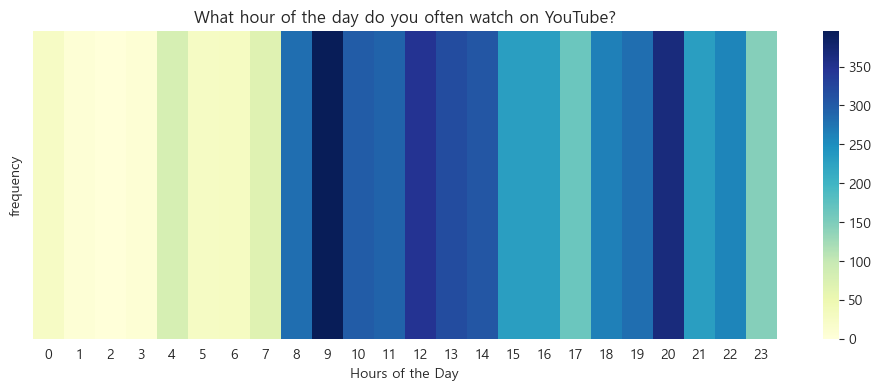

In [52]:
freq_viewed = df.copy()

# Convert the 'date_time' column to datetime
freq_viewed['date_time'] = pd.to_datetime(freq_viewed['date_time'], format='%b %d, %Y, %I:%M:%S %p')

# Set the 'date_time' column as the index
freq_viewed.set_index('date_time', inplace=True)

# Resample the data by hour and count the occurrences
freq_viewed = freq_viewed.resample('h').size()

# Reset the index to get the hour as a column
freq_viewed = freq_viewed.reset_index(name='frequency')

# Extract the hour from the 'date_time' column
freq_viewed['hour'] = freq_viewed['date_time'].dt.hour

# Aggregate data by hour
hourly_data = freq_viewed.groupby('hour')['frequency'].sum().reset_index()

# Create the heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(hourly_data.set_index('hour').T, cmap="YlGnBu", annot=False)
plt.title('What hour of the day do you often watch on YouTube?')
plt.xlabel('Hours of the Day')
plt.show()

## What day of the week do you often watch on YouTube?

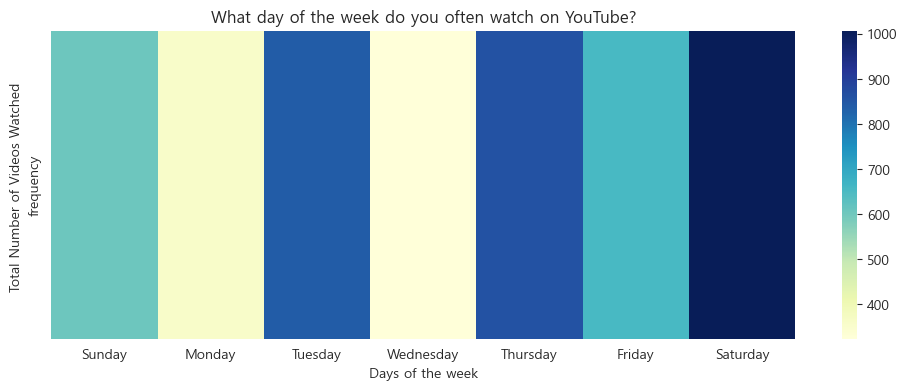

In [53]:
each_day = df.copy()
# Convert the 'date_time' column to datetime
each_day['date_time'] = pd.to_datetime(each_day['date_time'], format='%b %d, %Y, %I:%M:%S %p')

# Set the 'date_time' column as the index
each_day.set_index('date_time', inplace=True)

# Resample the data by hour and count the occurrences
each_day = each_day.resample('D').size()

# Reset the index to get the day as a column..
each_day = each_day.reset_index(name='frequency') 

# Extract the hour from the 'date_time' column
each_day['day_of_week'] = each_day['date_time'].dt.dayofweek

# Aggregate data by day
daily_data = each_day.groupby('day_of_week')['frequency'].sum().reset_index()

# Create the heatmap
plt.figure(figsize=(12, 4))
day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.heatmap(daily_data.set_index('day_of_week').T, cmap="YlGnBu", annot=False, xticklabels=day_names)
plt.title('What day of the week do you often watch on YouTube?')
plt.xlabel('Days of the week')
plt.ylabel('Total Number of Videos Watched ')
plt.show()

## Identify the frequency of videos watched base in their duration (minutes)

In [54]:
total_time = df.copy()

def time_convert(x):
    h,m,s = map(int,x.split(':'))
    return (h*60+m)*60+s

total_time['video_duration'] = total_time['video_duration'].astype('str').apply(time_convert)
total_time['video_duration'] = total_time['video_duration'] / 60

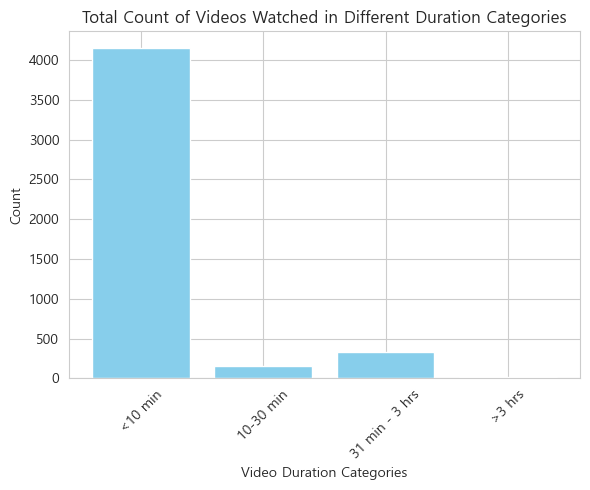

In [55]:
short_videos = len(total_time[total_time['video_duration'] <= 10])
medium_videos = len(total_time[(total_time['video_duration'] > 10) & (total_time['video_duration'] <= 30)])
long_videos = len(total_time[(total_time['video_duration'] > 30) & (total_time['video_duration'] <= 180)])
very_long_videos = len(total_time[total_time['video_duration'] > 180])

vid_durations = [short_videos, medium_videos, long_videos, very_long_videos]
categories = ['<10 min', '10-30 min', '31 min - 3 hrs', '>3 hrs']

# Plotting the bar chart
plt.figure(figsize=(6, 5))
plt.bar(categories, vid_durations, color='skyblue')
plt.xlabel('Video Duration Categories')
plt.ylabel('Count')
plt.title('Total Count of Videos Watched in Different Duration Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 

## Identify the frequency of videos watched base in their uploaded time

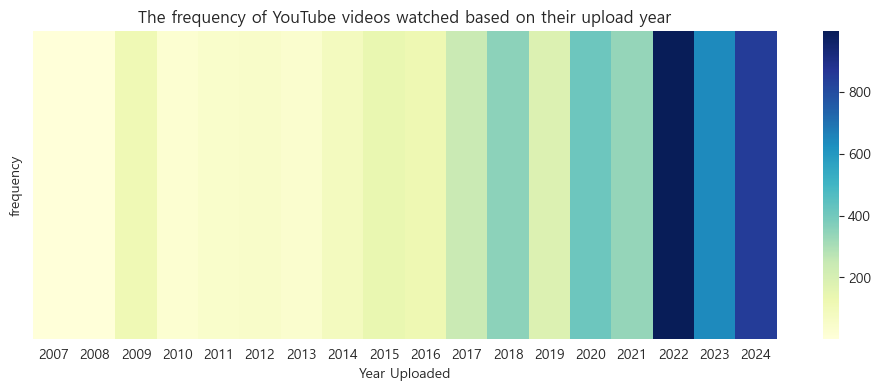

In [56]:
each_year = df.copy()

# Convert the 'date_time' column to datetime
each_year['video_date_upload'] = pd.to_datetime(each_year['video_date_upload'])

# Set the 'date_time' column as the index
each_year.set_index('video_date_upload', inplace=True)

# Resample the data by year and count the occurrences
each_year = each_year.resample('YE').size()

# Reset the index to get the year as a column
each_year = each_year.reset_index(name='frequency')

# Extract the year from the 'date_time' column
each_year['year'] = each_year['video_date_upload'].dt.year

# Aggregate data by year
by_year = each_year.groupby('year')['frequency'].sum().reset_index()

# Create the heatmap
plt.figure(figsize=(12, 4))
years = list(by_year['year'].unique())
sns.heatmap(by_year.set_index('year').T, cmap="YlGnBu", annot=False, xticklabels=years)
plt.title('The frequency of YouTube videos watched based on their upload year')
plt.xlabel('Year Uploaded')
plt.show()

## Frequency of YouTube videos watched by each category

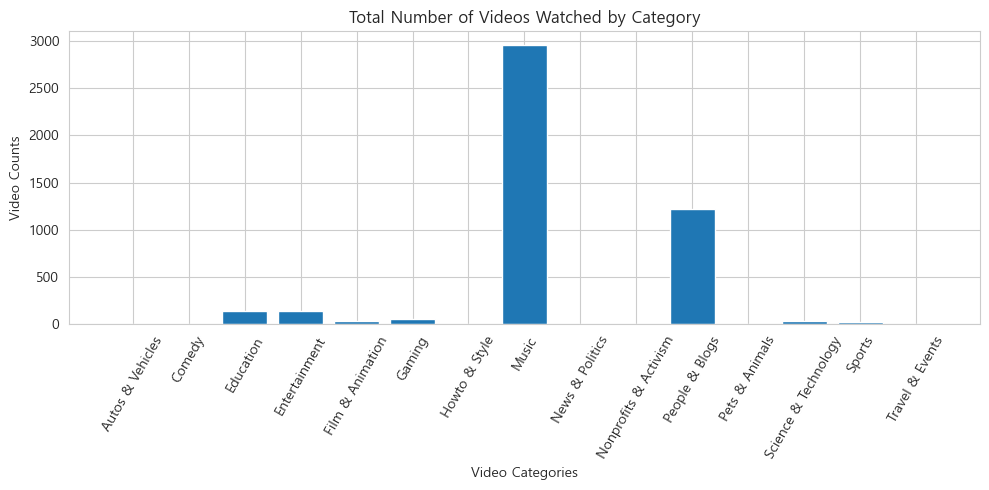

In [59]:
ratio_category = df.copy()

ratio_category = ratio_category.groupby('video_category').size()
ratio_category = ratio_category.reset_index(name='frequency')

vid_category = ratio_category['video_category']
freq = ratio_category['frequency']
# Plotting the bar chart
plt.figure(figsize=(10, 5))
plt.bar(vid_category.tolist(), freq.tolist(), label=vid_category.tolist())

plt.xlabel('Video Categories')
plt.ylabel('Video Counts')
plt.title('Total Number of Videos Watched by Category')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show() 

## Determine the total watch time of YouTube videos for each category

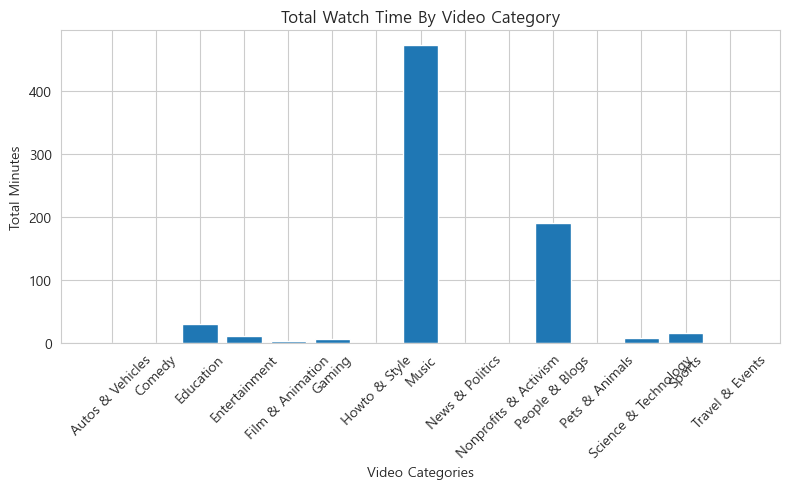

In [60]:
vid_category = vid_category.tolist()

total_watch_category = {
    key:None for key in vid_category
}


for category in vid_category:
    total_watch_category[category] = total_time[total_time['video_category'] == category]['video_duration'].sum()

# Convert dictionary to DataFrame
category_watch_times = pd.DataFrame(list(total_watch_category.items()), columns=['category', 'total_watch_time'])

category_watch_times['total_watch_time'] /= 60

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(category_watch_times['category'].tolist(), category_watch_times['total_watch_time'].tolist())

plt.xlabel('Video Categories')
plt.ylabel('Total Minutes')
plt.title('Total Watch Time By Video Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 
    

# Conclusion

Based on my analysis of my YouTube usage data, I have derived several key insights:

**Actual Watch Hours**: While YouTube data indicates a total of 730 watch hours, my actual usage is likely closer to 400 hours. This discrepancy arises because I frequently skip or do not fully watch many videos.

**Watching Patterns and Averages**: I have gained a deeper understanding of my viewing habits. This reflection has helped me identify how I allocate my time on the platform by examining my watching patterns and average watch times.

**Favorite Content**: I have identified my favorite YouTube videos and channels. This awareness allows me to recognize the types of content I am most engaged with and enjoy the most.

**Interesting Insights**: This analysis of my YouTube history data has revealed several interesting insights. For example, I can see trends in the types of videos I watch, the time of day I am most active, and other behavioral patterns.

**Realistic Usage**: My YouTube history data realistically reflects my usage, primarily for listening to music. This indicates that YouTube serves as a significant source of audio content for me. Well, YouTube is the only platform where I listen to music.

Overall, this analysis has provided a comprehensive view of my YouTube usage. It highlights my viewing habits and preferences that truly reflects with my realistic usage. These patterns can help me to manage my time better and make more informed choices about my media consumption.
